<table style="width :100%;">
    <td style="width : 7.5%;">
        <img style="float: left;
                width: 75px;"
         src="https://upload.wikimedia.org/wikipedia/fr/d/d9/Logo_T%C3%A9l%C3%A9com_ParisTech.svg" />
    </td>
    <td style="width : 15%;">
        TELECOM PARIS<br />2021/2022<br /><br /> MDI720<br />Mr Francis WOLINSKI
    </td>
    <td>
        <h1><center>KIT DATA<br /><br />Projet final du Kit Data Science 2021</center></h1>
    </td>
    <td style="width : 12.5%;">
        Victor LEDEZ <br />Date TP : 2021/10/26<br /><br /> Date CR : 2021/11/7<br /> Version : 1
    </td>
</table>

# Projet final du Kit Data Science 2021
Le projet final du Kit Data Science 2021 porte sur les données du **Vendée Globe 2020-2021**.

Le projet se déroule **26 octobre au 7 novembre 2021** date limite pour rendre vos projets respectifs.

Les données du dernier Vendée Globe sont disponibles sous la forme de fichiers Excel avec les classements fournis plusieurs fois par jour par les organisateurs de la course. Il y a également une page web avec une fiche technique par voilier qui contient des informations techniques et qu'il est possible de rapprocher des classements.

Il vous appartient de charger les données en Python, de procéder aux préparations nécessaires et d'effectuer les analyses pertinentes de votre choix.

Le rendu sera un notebook Jupyter fourni aux formats ipynb et HTML.

**Barème sur 15 points** :

- Acquisition et chargement des données : 3 points
- Préparation des données : 5 points
- Analyses et story telling : 7 points

**Exemples de traitements et d'analyses** :

- Récupération des fichiers Excel avec les classements
  1. Mettre en place une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
  2. Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.
- Extraction des caractéristiques techniques de chacun des voiliers.
- Rapprochement des données des voiliers avec celle des classements.
- Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
- Impact de la présence d'un *foil* sur le classement et la vitesse des voiliers.
- Visualisation de la distance parcourue par voilier.
- Cartes avec les routes d'un ou plusieurs voiliers.
- Analyses de séries temporelles.
- Application d'algorithmes statistiques ou de machine learning.
- etc.

**Sources des données**

- Page web donnant accès aux fichiers Excel des classements du Vendée Globe : https://www.vendeeglobe.org/fr/classement
- Page web avec les fiches techniques des voiliers du Vendée Globe : https://www.vendeeglobe.org/fr/glossaire
- Site web donnant accès à des fichiers avec les formes géométriques des côtes : https://www.naturalearthdata.com/ (ou bien utilisez les librairies plotly ou ipyleaflet pour produire des cartes)
- etc.

**Questions/Réponses**

Les questions et réponses seront publiées ci-après au fil de l'eau :

1. Qu'est-ce qu'un *foil* ? https://www.vendeeglobe.org/fr/actualites/19755/quels-foils-pour-gagner-le-vendee-globe La présence d'un *foil* est indiqué dans l'attribut "Nombre de dérives" dans les fiches techniques des voiliers.
2. S'agit-il d'un travail individuel ou collectif ? Il s'agit bien d'un travail individuel.
3. Est-il possible de rendre plusieurs notebooks afin de délimiter clairement les différentes étapes du projet ? Tout peut tenir dans un seul notebook mais pourquoi pas.
4. Y a-t-il une norme pour le code ? Vous pouvez regarder la [PEP8](https://www.python.org/dev/peps/pep-0008/) (voir [Naming Conventions](https://www.python.org/dev/peps/pep-0008/#toc-entry-21) pour les noms de variables et de fonctions)  mais le projet n'est particulièrement noté sur ce point.
5. Faut-il créer un unique DataFrame mettant à chaque classement d'afficher les caractéristiques des voiliers ou bien peut-on gérer les 2 types de données indépendamment ? C'est à vous de voir en fonction des analyses que vous voulez produire.
6. Peut-on produire des graphiques supplémentaires à ceux proposés ? Oui, vous avez toute latitude pour produire les analyses de votre choix à partir des données.
7. Comment peut-on télécharger les fichier Excel pour ensuite les lire avec `pandas`? Voir ci-dessous :

`from urllib import request`

`import shutil`

`url = 'URL du fichier Excel à télécharger'`

`filename = 'exemple.xlsx'`

`with request.urlopen(url) as response, open(filename, 'wb') as out_file:`
    `shutil.copyfileobj(response, out_file)`

**Avertissement**

Vous devez publier votre **notebook exécuté aux formats ipynb et HTML** sur votre github **avant le dimanche 7 novembre 2021 à 23h59** et lorsque c'est fait **envoyer une notification par email avec le lien du projet** à l'adresse `contact(at)yotta-conseil.fr`

<hr>

#### Modules Imports

<hr>

In [1]:
import os
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

import datetime as dt
import dateparser

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import tempfile
from zipfile import ZipFile
import shutil
from fnmatch import fnmatch
import re

from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go

<hr>

#### Main Variables

<hr>

In [2]:
URL_CLASSEMENT = 'https://www.vendeeglobe.org/fr/classement'
URL_BOATS = 'https://www.vendeeglobe.org/fr/glossaire'
SKIPPERS = ['Charlie Dalin', 'Louis Burton', 'Boris Herrmann']


<hr>

#### Utils Functions

<hr>

Fonction qui convertit les coordonnées en format décimal

In [3]:
def convert_decimal(degrees, minutes, seconds):
    return degrees + minutes / 60 + seconds / 3600

<hr>

# 1. Téléchargement des données 'Classement' du vendéeglobe

<hr>

In [4]:
response = requests.get(URL_CLASSEMENT)
soup = BeautifulSoup(response.content)
dates = soup.find('select', {'class':"form__input m--select onsubmit-rank"}).findAll('option')
labels =  sorted([dates[i].get('value') for i in range(len(dates))][1:])
labels = labels[2:labels.index("20210127_140000")]

for date in labels:
    resp = requests.get(
        f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_{str(date)}.xlsx')
        
    with open(f'Classements/{str(date)}.xlsx', 'wb') as output:
        output.write(resp.content)


Fonction pour réparer les xlsx récupées

In [5]:
def change_in_zip(file_name, name_filter, change):
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)           
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)


Liste avec les chemins des fichiers

In [6]:
directory = r'Classements/'
paths = []
for entry in os.scandir(directory):
    if (entry.path.endswith(".xlsx")) & ~(entry.path.startswith("Classements/~")):
        paths.append(entry.path)
paths = sorted(paths)
paths[:20]


['Classements/20201108_150000.xlsx',
 'Classements/20201108_170000.xlsx',
 'Classements/20201108_210000.xlsx',
 'Classements/20201109_040000.xlsx',
 'Classements/20201109_080000.xlsx',
 'Classements/20201109_110000.xlsx',
 'Classements/20201109_140000.xlsx',
 'Classements/20201109_170000.xlsx',
 'Classements/20201109_210000.xlsx',
 'Classements/20201110_040000.xlsx',
 'Classements/20201110_080000.xlsx',
 'Classements/20201110_110000.xlsx',
 'Classements/20201110_140000.xlsx',
 'Classements/20201110_170000.xlsx',
 'Classements/20201110_210000.xlsx',
 'Classements/20201111_040000.xlsx',
 'Classements/20201111_080000.xlsx',
 'Classements/20201111_110000.xlsx',
 'Classements/20201111_140000.xlsx',
 'Classements/20201111_170000.xlsx']

Réparation des fichiers

In [7]:
for path in paths:
    change_in_zip(path, 
              name_filter='xl/styles.xml',
              change=lambda d: re.sub(b'xxid="\d*"', b"", d))

Définition de la fonction qui acquiert et nettoie les données

In [8]:
def cleaning(path):

    df = pd.read_excel(path, header=[3,4], nrows=25)

    title = pd.read_excel(path, header=1, nrows=1)['Unnamed: 1'].str.extract('Classement du (.*) FR')
    stamp = dateparser.parse(title[0][0])
    df['Stamp'] = stamp

    df['Rank'] = df['Rang\nRank']['Unnamed: 1_level_1'].astype(int)
    df[['Nat', 'Voile']] = df['Nat. / Voile\nNat. / Sail']['Unnamed: 2_level_1'].str.strip('\n').str.replace('\nFRA','').str.split(' ', expand=True)
    df[['Skipper', 'Bateau']] = df['Skipper / Bateau\nSkipper / crew']['Unnamed: 3_level_1'].str.split('\n', expand=True)

    df['Position_Hour'] = df['Skipper / Bateau\nSkipper / crew']['Heure FR\nHour FR'].str.split(' FR\n', expand=True)[0].str.replace(':','H') + 'MIN'
    df['Position_Hour'] = pd.to_timedelta(df['Position_Hour'])

    df['Position_Longitude'] = df['Skipper / Bateau\nSkipper / crew']['Longitude\nLongitude']
    df['Position_Latitude'] = df['Skipper / Bateau\nSkipper / crew']['Latitude\nLatitude']

    A = df['Position_Longitude'].str.extract("(.*)°(..).(..)'.").astype(int)
    A['D'] =df['Position_Longitude'].str.extract(".*'(.)").astype(str)
    df['Position_Longitude_decimale'] = convert_decimal(A[0],A[1],A[2])
    df['Position_Longitude_decimale'] = np.where(A['D'] == 'W', -df['Position_Longitude_decimale'], df['Position_Longitude_decimale'])

    B = df['Position_Latitude'].str.extract("(.*)°(..).(..)'.").astype(int)
    B['D'] = df['Position_Latitude'].str.extract(".*'(.)").astype(str)
    df['Position_Latitude_decimale'] = convert_decimal(B[0],B[1],B[2])
    df['Position_Latitude_decimale'] = np.where(B['D'] == 'S', -df['Position_Latitude_decimale'], df['Position_Latitude_decimale'])

    df["Depuis 30 minutes_Cap"] = df['Depuis 30 minutes\nSince 30 minutes']['Cap\nHeading'].str.strip('°').astype(float)
    df["Depuis 30 minutes_Vitesse"] = df['Depuis 30 minutes\nSince 30 minutes']['Vitesse\nSpeed'].str.strip(' kts').astype(float)
    df["Depuis 30 minutes_VMG"] = df['Depuis 30 minutes\nSince 30 minutes']['VMG\nVMG'].str.strip(' kts').astype(float)
    df["Depuis 30 minutes_Distance"] = df['Depuis 30 minutes\nSince 30 minutes']['Distance\nDistance'].str.strip(' nm').astype(float)

    df["Depuis le dernier classement_Cap"] = df['Depuis le dernier classement\nSince the the last report']['Cap\nHeading']\
    .str.strip('°').astype(float)
    df["Depuis le dernier classement_Vitesse"] = df['Depuis le dernier classement\nSince the the last report']['Vitesse\nSpeed']\
    .str.strip(' kts').astype(float)
    df["Depuis le dernier classement_VMG"] = df['Depuis le dernier classement\nSince the the last report']['VMG\nVMG']\
    .str.strip(' kts').astype(float)
    df["Depuis le dernier classement_Distance"] = df['Depuis le dernier classement\nSince the the last report']['Distance\nDistance']\
    .str.strip(' nm').astype(float)

    df["Depuis 24 heures_Cap"] = df['Depuis 24 heures\nSince 24 hours']['Cap\nHeading'].str.strip('°').astype(float)
    df["Depuis 24 heures_Vitesse"] = df['Depuis 24 heures\nSince 24 hours']['Vitesse\nSpeed'].str.strip(' kts').astype(float)
    df["Depuis 24 heures_VMG"] = df['Depuis 24 heures\nSince 24 hours']['VMG\nVMG'].str.strip(' kts').astype(float)
    df["Depuis 24 heures_Distance"] = df['Depuis 24 heures\nSince 24 hours']['Distance\nDistance'].str.strip(' nm').astype(float)

    df['DTF_'] = df['DTF']['Unnamed: 19_level_1'].str.strip(' nm').astype(float)
    df['DTL_'] = df['DTL']['Unnamed: 20_level_1'].str.strip(' nm').astype(float)

    columns = ['Stamp', 'Rank','Nat', 'Voile', 'Skipper', 'Bateau','Position_Hour','Position_Longitude',\
               'Position_Latitude','Position_Longitude_decimale','Position_Latitude_decimale',\
              "Depuis 30 minutes_Cap",'Depuis 30 minutes_Vitesse','Depuis 30 minutes_VMG','Depuis 30 minutes_Distance',\
              "Depuis le dernier classement_Cap","Depuis le dernier classement_Vitesse","Depuis le dernier classement_VMG",'Depuis le dernier classement_Distance',\
              "Depuis 24 heures_Cap","Depuis 24 heures_Vitesse","Depuis 24 heures_VMG","Depuis 24 heures_Distance",\
              "DTF_","DTL_"]
    df = df[columns]

    return df


In [9]:
df = cleaning(paths[0])
i=0
for path in paths:
    i+=1
    df = df.append(cleaning(path))
    if i % 50 == 0: print(i)
df.head()

C:\Users\ledez\AppData\Local\Programs\Python\Python39\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


50
100
150
200
250
300
350
400
450


,Stamp,Rank,Nat,Voile,Skipper,Bateau,Position_Hour,Position_Longitude,Position_Latitude,Position_Longitude_decimale,...,Depuis le dernier classement_Cap,Depuis le dernier classement_Vitesse,Depuis le dernier classement_VMG,Depuis le dernier classement_Distance,Depuis 24 heures_Cap,Depuis 24 heures_Vitesse,Depuis 24 heures_VMG,Depuis 24 heures_Distance,DTF_,DTL_
,,,,,,,,,,,...,,,,,,,,,,
0,2020-11-08 17:00:00,1,FRA,8,Jérémie Beyou,Charal,0 days 17:00:00,02°35.50'W,46°20.72'N,-2.597222,...,262.0,21.1,19.7,31.7,254.0,1.4,1.4,34.5,24265.1,0.0
1,2020-11-08 17:00:00,2,FRA,79,Charlie Dalin,APIVIA,0 days 17:00:00,02°31.45'W,46°17.46'N,-2.529167,...,357.0,0.0,0.0,2782.5,247.0,1.4,1.4,32.9,24265.8,0.7
2,2020-11-08 17:00:00,3,GBR,99,Alex Thomson,Hugo Boss,0 days 17:00:00,02°31.66'W,46°18.68'N,-2.535000,...,257.0,19.9,19.1,29.9,249.0,1.4,1.3,32.7,24266.3,1.2
3,2020-11-08 17:00:00,4,FRA,59,Thomas Ruyant,LinkedOut,0 days 17:00:00,02°32.29'W,46°19.45'N,-2.541389,...,260.0,19.9,18.9,29.9,251.0,1.4,1.3,32.7,24266.3,1.2
4,2020-11-08 17:00:00,5,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,0 days 17:00:00,02°29.63'W,46°18.22'N,-2.500833,...,257.0,19.0,18.2,28.2,248.0,1.3,1.3,31.5,24267.3,2.2


In [10]:
df.shape

(12025, 25)

Saving the df to pickle for faster access

In [11]:
df = df.set_index('Stamp').sort_index()
df.columns = df.columns.droplevel(1)
path = 'Classements.pkl'
df.to_pickle(path)

In [12]:
df = pd.read_pickle('Classements.pkl')
df.head()

,Rank,Nat,Voile,Skipper,Bateau,Position_Hour,Position_Longitude,Position_Latitude,Position_Longitude_decimale,Position_Latitude_decimale,...,Depuis le dernier classement_Cap,Depuis le dernier classement_Vitesse,Depuis le dernier classement_VMG,Depuis le dernier classement_Distance,Depuis 24 heures_Cap,Depuis 24 heures_Vitesse,Depuis 24 heures_VMG,Depuis 24 heures_Distance,DTF_,DTL_
Stamp,,,,,,,,,,,,,,,,,,,,,
2020-11-08 17:00:00,1,FRA,8,Jérémie Beyou,Charal,0 days 17:00:00,02°35.50'W,46°20.72'N,-2.597222,46.353333,...,262.0,21.1,19.7,31.7,254.0,1.4,1.4,34.5,24265.1,0.0
2020-11-08 17:00:00,2,FRA,79,Charlie Dalin,APIVIA,0 days 17:00:00,02°31.45'W,46°17.46'N,-2.529167,46.296111,...,357.0,0.0,0.0,2782.5,247.0,1.4,1.4,32.9,24265.8,0.7
2020-11-08 17:00:00,3,GBR,99,Alex Thomson,Hugo Boss,0 days 17:00:00,02°31.66'W,46°18.68'N,-2.535000,46.318889,...,257.0,19.9,19.1,29.9,249.0,1.4,1.3,32.7,24266.3,1.2
2020-11-08 17:00:00,4,FRA,59,Thomas Ruyant,LinkedOut,0 days 17:00:00,02°32.29'W,46°19.45'N,-2.541389,46.329167,...,260.0,19.9,18.9,29.9,251.0,1.4,1.3,32.7,24266.3,1.2
2020-11-08 17:00:00,5,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,0 days 17:00:00,02°29.63'W,46°18.22'N,-2.500833,46.306111,...,257.0,19.0,18.2,28.2,248.0,1.3,1.3,31.5,24267.3,2.2


<hr>

# 2. Données des bateaux

<hr>

Définition de la fonction qui acquiert et nettoie les données sur les bateaux

In [13]:
def get_and_clean(path):

    response = requests.get(path)

    soup = BeautifulSoup(response.content)
    Boats_info = soup.findAll('div', {'class':"boats-list__infos"})
    Boat_name = []
    Skipper_name = []
    for boat in Boats_info : 
        Boat_name.append(boat.find('h3').text)
        Skipper_name.append(boat.find('span').text)

    soup = BeautifulSoup(response.content)
    boats = soup.findAll('ul', {'class':"boats-list__popup-specs-list"})
    Boats = {}
    for boat in boats:
        boat = boat.findAll('li')
        name = boat[0].text.split(' : ')[1]
        Boats[name] = {}
        for line in boat[1:]:
            key = line.text.split(' : ')[0]
            val = line.text.split(' : ')[1]

            Boats[name][key] = val
    Boats = pd.DataFrame(Boats).T
    Boats['Date de lancement'] = Boats['Date de lancement'].apply(dateparser.parse)
    Boats['Longueur (m)'] = Boats['Longueur'].str.strip(' m').str.replace(',','.').astype('float')
    Boats['Largeur (m)'] = Boats['Largeur'].str.strip(' m').str.replace(',','.').astype('float')
    Boats["Tirant d'eau (m)"] = Boats["Tirant d'eau"].str.strip(' m').str.replace(',','.').astype('float')
    Boats["Déplacement (poids) (T)"] = Boats["Déplacement (poids)"].str.strip(' t').str.strip(' tonnes')\
    .str.replace('[a-zA-Z]', '0', regex=True).str.replace(',','.').astype(float)
    Boats["Hauteur mât (m)"] = Boats["Hauteur mât"].str.strip(' m').str.replace(',','.').astype('float')
    Boats["Surface de voiles au près (m2)"] = Boats["Surface de voiles au près"].str.strip(' m2').str.strip(' m²').str.replace(',','.').astype('float')
    Boats["Surface de voiles au portant (m2)"] = Boats["Surface de voiles au portant"].str.strip(' m2').str.strip(' m²').str.replace(',','.').astype('float')
    Boats['Skipper'] = Skipper_name
    Boats['Skipper'] = Boats['Skipper'].apply(lambda x : str.title(x)).str.replace('  ',' ')
    Boats = Boats.replace("Sam Davies","Samantha Davies")
    Boats = Boats.replace("Arnaud Boissières","Arnaud Boissieres")
    Boats['Bateau2'] = Boat_name


    Boats.columns
    columns = ['Skipper','Bateau2','Anciens noms du bateau', 'Architecte', 'Chantier', 'Date de lancement',
           'Longueur (m)', 'Largeur (m)', "Tirant d'eau (m)", 'Déplacement (poids) (T)',
           'Nombre de dérives', 'Hauteur mât (m)', 'Voile quille',
           'Surface de voiles au près (m2)', 'Surface de voiles au portant (m2)']
    Boats = Boats[columns]

    Boats["Anciens noms du bateau"] = Boats["Anciens noms du bateau"].fillna('')
    Boats["Architecte"] = Boats["Architecte"].fillna('')
    Boats["Voile quille"] = Boats["Voile quille"].fillna('')
    
    return Boats


In [14]:
Boats = get_and_clean(URL_BOATS)

C:\Users\ledez\AppData\Local\Programs\Python\Python39\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Saving the Boats df to pickle for faster access

In [15]:
path = 'Boats.pkl'
Boats.to_pickle(path)

In [16]:
Boats = pd.read_pickle('Boats.pkl')
Boats.head()

,Skipper,Bateau2,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids) (T),Nombre de dérives,Hauteur mât (m),Voile quille,Surface de voiles au près (m2),Surface de voiles au portant (m2)
FRA 56,Fabrice Amedeo,NEWREST - ART & FENÊTRES,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,2015-08-01,18.28,5.85,4.5,7.0,foils,29.0,monotype,320.0,570.0
FRA 49,Romain Attanasio,PURE - Best Western®,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),2007-03-08,18.28,5.80,4.5,9.0,2,28.0,acier forgé,80.0,560.0
FRA72,Alexia Barrier,TSE - 4MYPLANET,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,1998-03-01,18.28,5.54,4.5,9.0,2,29.0,acier,60.0,580.0
17,Yannick Bestaven,Maître CoQ IV,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,2015-03-12,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310.0,550.0
08,Jérémie Beyou,CHARAL,,VPLP,CDK Technologies,2018-08-18,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0


Merge the Classements and Boats dataframes

In [17]:
df = df.reset_index()
df_merge = df.merge(Boats, on="Skipper", how='left')
df_merge = df_merge.set_index('Stamp').sort_index()

path = 'Merged.pkl'
df_merge.to_pickle(path)

In [18]:
Merged = pd.read_pickle('Merged.pkl')
Merged.head()

,Rank,Nat,Voile,Skipper,Bateau,Position_Hour,Position_Longitude,Position_Latitude,Position_Longitude_decimale,Position_Latitude_decimale,...,Date de lancement,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids) (T),Nombre de dérives,Hauteur mât (m),Voile quille,Surface de voiles au près (m2),Surface de voiles au portant (m2)
Stamp,,,,,,,,,,,,,,,,,,,,,
2020-11-08 17:00:00,1,FRA,8,Jérémie Beyou,Charal,0 days 17:00:00,02°35.50'W,46°20.72'N,-2.597222,46.353333,...,2018-08-18,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0
2020-11-08 17:00:00,2,FRA,79,Charlie Dalin,APIVIA,0 days 17:00:00,02°31.45'W,46°17.46'N,-2.529167,46.296111,...,2019-08-05,18.28,5.85,4.5,8.0,foils,29.0,acier,350.0,560.0
2020-11-08 17:00:00,3,GBR,99,Alex Thomson,Hugo Boss,0 days 17:00:00,02°31.66'W,46°18.68'N,-2.535000,46.318889,...,2019-08-15,18.28,5.40,4.5,7.7,foils,29.0,acier forgé,330.0,630.0
2020-11-08 17:00:00,4,FRA,59,Thomas Ruyant,LinkedOut,0 days 17:00:00,02°32.29'W,46°19.45'N,-2.541389,46.329167,...,2019-09-03,18.28,5.85,4.5,8.0,foils,29.0,acier forgé,350.0,560.0
2020-11-08 17:00:00,5,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,0 days 17:00:00,02°29.63'W,46°18.22'N,-2.500833,46.306111,...,2015-08-07,18.28,5.70,4.5,7.6,foils,29.0,acier,90.0,490.0


In [19]:
Merged["Nombre de dérives"].unique()

array(['foils', 'foiler', '2', '2 asymétriques'], dtype=object)

In [20]:
Merged.loc[Merged["Nombre de dérives"] == "foiler", "Skipper"].unique()

array(['Sébastien Simon'], dtype=object)

## Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

Correlation entre le rang et la vitesse VMG depuis 24 heures:

- Coefficient : -0.1141
- Intercept : 13.1535
- Score R2 : 0.9271



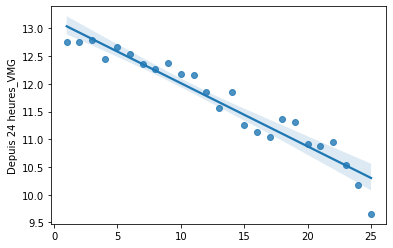

In [23]:
VMG_Rank_last_24h = pd.DataFrame(df.groupby('Rank')['Depuis 24 heures_VMG'].mean())
Rank = VMG_Rank_last_24h.index.values.reshape(-1,1)
VMG_last_24h = VMG_Rank_last_24h["Depuis 24 heures_VMG"]

linreg = LinearRegression(fit_intercept=True)
linreg.fit(Rank, VMG_last_24h)
VMG_pred = linreg.predict(Rank)

coef = np.round(linreg.coef_[0],4)
intercept = np.round(linreg.intercept_,4)
r2 = np.round(sklearn.metrics.r2_score(VMG_last_24h, VMG_pred),4)

print(f'Correlation entre le rang et la vitesse VMG depuis 24 heures:\n\n\
- Coefficient : {coef}\n\
- Intercept : {intercept}\n\
- Score R2 : {r2}\n')

sns.regplot(x = Rank, y = VMG_last_24h, data = VMG_Rank_last_24h);


## Visualisation des distances cumulées parcourues par les 3 premiers skippers.

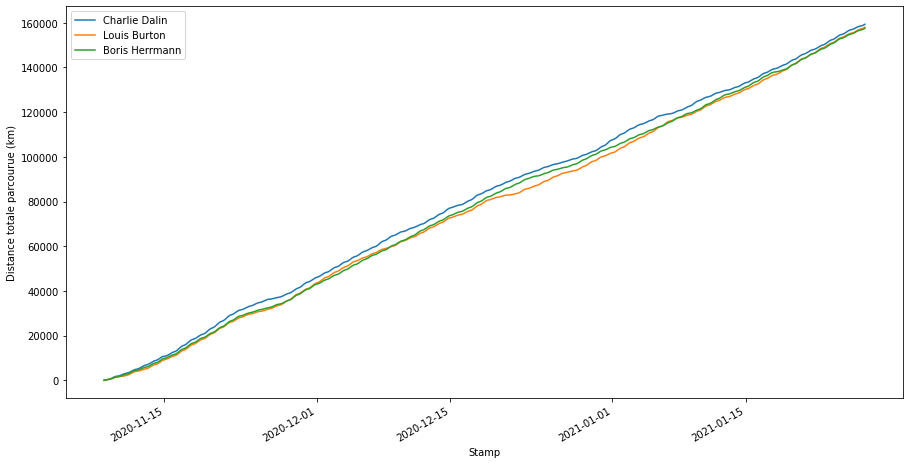

In [24]:
fig = plt.subplots(1, figsize=(15,8))

for skipper in SKIPPERS[:3]:
    skip = Merged.loc[(Merged['Skipper'] == skipper),"Depuis 24 heures_Distance"]
    skip.cumsum().plot(label = skipper)

plt.ylabel('Distance totale parcourue (km)')
plt.legend();

## Visualisation sur une carte des parcours des 3 premiers skippers.

In [25]:
fig = go.Figure(go.Scattermapbox())
i=0
for skipper in SKIPPERS: 
    sk = df.loc[df['Skipper'] == skipper]
    stamp = sk.index

    fig.add_trace(go.Scattermapbox(
        
        mode = "markers+lines",
        lon = sk["Position_Longitude_decimale"],
        lat = sk["Position_Latitude_decimale"],
        name = skipper,
        marker = {'size': 3},
                text= stamp ))
    i+=1
     

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': 10, 'lat': 10},
        'style': "stamen-terrain",
        'center': {'lon': -20, 'lat': -20},
        'zoom': 1})

fig.show()